## Overhead

In [1]:
import json
from IPython.display import display, Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

### Load data

In [2]:
def load_data(path: str):
    with open(path) as file:
        json_data = json.load(file)
    df = pd.DataFrame(json_data)

    if "_id" in df.columns:
        df = df.drop(columns="_id")

    return df

unobfuscated_data = load_data("./data/unoptimized/unobfuscated.json")
tigress_data = load_data("./data/unoptimized/tigress.json")
llvm_data = load_data("./data/unoptimized/llvm.json")
wasm_mutate_data = load_data("./data/unoptimized/wasm-mutate.json")

### Pre-process data

In [3]:
transformation_label_map = {
    "flatten": "Flattening",
    "randomfuns": "Random Functions",
    "encodearithmetic": "Encode Arithmetic",
    "encodeliterals": "Encode Literals",
    "split": "Function Splitting",
    "virtualize": "Virtualization",
    "antitaintanalysis": "Anti Taint Analysis",
    "antialiasanalysis": "Anti Alias Analysis"
}

# Create a new column 'transformation_label' based on the 'transformation' column values
tigress_data['transformation_label'] = tigress_data['transformation'].map(transformation_label_map)

# Create a new column 'transformation_label' based on the 'transformation' column values
transformation_label_map = {
    "cffobf": "Control Flow Flattening",
    "bcfobf": "Bogus Control Flow",
    "constenc": "Constants Encryption",
    "strcry": "String Encryption",
    "splitobf": "Basic Block Splitting",
    "indibran": "Indirect Branches",
    "subobf": "Substitute Instruction",
    "funcwra": "Function Wrapper"
}
llvm_data['transformation_label'] = llvm_data['transformation'].map(transformation_label_map)

# Create a new column 'transformation_label' based on the 'mutator' column values
wasm_mutate_data['transformation'] = wasm_mutate_data['mutator']
transformation_label_map = {
    "AddCustomSectionMutator": "Add Custom Section",
    "PeepholeMutator": "Peephole",
    "CodemotionMutator": "Code Motion",
    "AddTypeMutator": "Add Type",
    "AddFunctionMutator": "Add Function",
    "RemoveSection": "Remove Section",
    "RemoveItemMutator": "Remove Item",
    "ReorderCustomSectionMutator": "Reorder Custom Section", 
    "CustomSectionMutator": "Custom Section"
}
wasm_mutate_data['transformation_label'] = wasm_mutate_data['transformation'].map(transformation_label_map)

### Compute file size increase

In [4]:
def compute_relative_file_size(unobf_df, obf_df):
    obf_df['relative_file_size'] = None

    for index, row in obf_df.iterrows():
        name = row['name']
        file_size = row['file_size']
        unobf_file_size = unobf_df.loc[unobf_df['name'] == name, 'file_size'].iloc[0]
        relative_file_size = ((file_size / unobf_file_size) - 1) * 100

        obf_df.at[index, 'relative_file_size'] = relative_file_size
    return obf_df

tigress_data = compute_relative_file_size(unobfuscated_data, tigress_data)
llvm_data = compute_relative_file_size(unobfuscated_data, llvm_data)
wasm_mutate_data = compute_relative_file_size(unobfuscated_data, wasm_mutate_data)

### Configure Seaborn

In [5]:
sns.set_theme(
    style="whitegrid",
    context="paper",
    font_scale=1.2,
    rc = {
      "figure.figsize": (10, 6),
      "errorbar.capsize": 0.05,
      "xtick.color": "#646464",
      "ytick.color": "#646464",
      "legend.loc": "best",
      "font.family": "Ubuntu",
    }
)

palette = "tab20"
edgecolor = "#646464"
errwidth = 1.8
capsize = 0.05

blues = sns.color_palette("Blues", n_colors= 1)
greens = sns.color_palette("Greens", n_colors=1)
reds = sns.color_palette("Reds", n_colors=1)

bgr_palette = blues + greens + reds
grb_palette = greens + reds + blues

#### Relative file size increase by transformation

/tmp/ipykernel_10642/3582479441.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wasm_mutate_data['method'] = 'wasm-mutate'


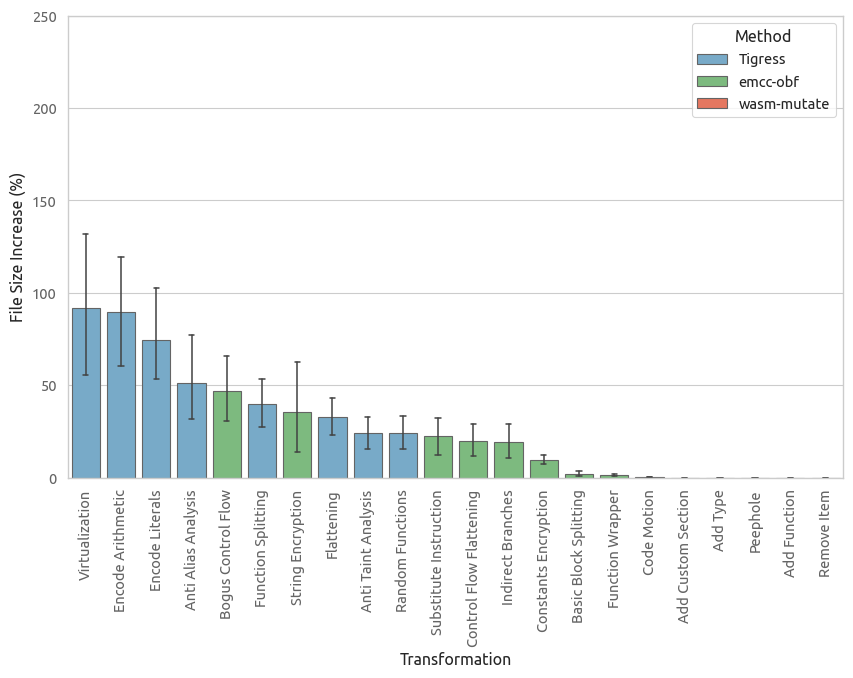

In [6]:
def plot_file_size_increase_by_transformation(df, xlabel, palette=None, path=None):
    
    # Compute the average distance for each transformation_label
    avg_distance = df.groupby('transformation_label')['relative_file_size'].mean().reset_index()
    
    # Sort DataFrame by descending values of the average distance
    avg_distance_sorted = avg_distance.sort_values('relative_file_size', ascending=False)

    # Use the sorted order to sort the original DataFrame by transformation_label
    df['transformation_label'] = pd.Categorical(df['transformation_label'],
                                                categories=avg_distance_sorted['transformation_label'],
                                                ordered=True)
    
    sorted_df = df.sort_values('transformation_label')

    sns.barplot(data=sorted_df, 
                x='transformation_label', 
                y='relative_file_size', 
                hue='method',
                dodge=False,
                palette=palette, 
                errwidth=1.1, 
                capsize=0.15, 
                edgecolor=edgecolor,
                )
    
    # Axis labels
    plt.ylabel('File Size Increase (%)')
    plt.xlabel(xlabel)

    plt.xticks(rotation=90)

    # Capitalize the first letter of the entries in the legend
    plt.legend(title='Method', loc='upper right')

    plt.ylim(0, 250)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

# filter wasm-mutate data
filtered_wasm_mutate_data = wasm_mutate_data[wasm_mutate_data['iteration'] == -1]

# Add a 'method' column to each dataframe
tigress_data['method'] = 'Tigress'
llvm_data['method'] = 'emcc-obf'
filtered_wasm_mutate_data['method'] = 'wasm-mutate'

# Concatenate all dataframes in the desired order: tigress, llvm, wasm_mutate
df = pd.concat([tigress_data, llvm_data, filtered_wasm_mutate_data], ignore_index=True)
plot_file_size_increase_by_transformation(df, xlabel='Transformation', palette=bgr_palette, path='./plots/overhead/file-size.pdf')

#### wasm-mutate relative file size increase by iteration

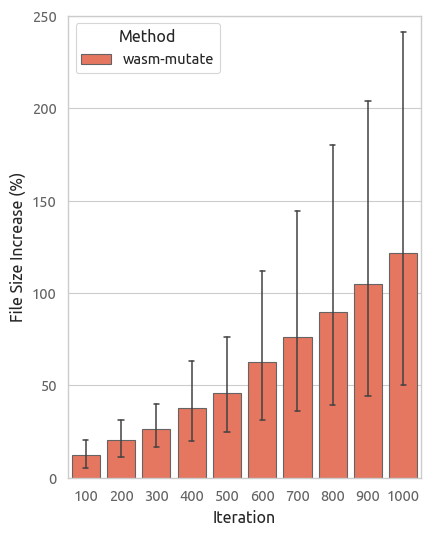

In [7]:
def plot_wasm_mutate_distance(df, palette=palette, path=None):
    plt.figure(figsize=(4.55,6))
    sns.barplot(data=df, 
                x='iteration', 
                y='relative_file_size',
                hue='method',
                palette=palette, 
                errwidth=1.1, 
                capsize=0.15, 
                edgecolor=edgecolor,
                )
    
    # Axis labels
    plt.ylabel('File Size Increase (%)')
    plt.xlabel('Iteration')

    # Capitalize the first letter of the entries in the legend
    plt.legend(title='Method', loc='best')

    plt.ylim(0, 250)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

# Filter wasm-mutate data
df = wasm_mutate_data[wasm_mutate_data['iteration'] != -1]
df = df[df['distance'].notnull()]
df['method'] = 'wasm-mutate'

red = sns.color_palette("Reds", n_colors=1)
plot_wasm_mutate_distance(df, palette=red, path='./plots/overhead/file-size-mutate.pdf')

### Hash rate

#### Compute hash rates

In [8]:
def compute_hash_rates(df):
    def actual_hash_rate(row):
        if isinstance(row['hash_rate'], dict) and 'hash_count' in row['hash_rate']:
            hash_count = row['hash_rate']['hash_count']
            total_hashes = hash_count[-1]
            duration = len(hash_count) - 1
            return total_hashes / duration
        else:
            return np.nan

    def raw_hash_rate(row):
        if isinstance(row['hash_rate'], dict) and 'hash_count' in row['hash_rate']:
            hash_count = row['hash_rate']['hash_count']
            non_zero_hashes = [h for h in hash_count if h != 0]
            if not non_zero_hashes:
                return np.nan
            total_hashes = non_zero_hashes[-1]
            duration = len(non_zero_hashes) - 1
            return total_hashes / duration
        else:
            return np.nan

    def raw_hash_rate_last_10s(row):
        if isinstance(row['hash_rate'], dict) and 'hash_count' in row['hash_rate']:
            hash_count = row['hash_rate']['hash_count']
            non_zero_hashes = [h for h in hash_count if h != 0]
            if len(non_zero_hashes) < 10:
                return np.nan
            total_hashes = non_zero_hashes[-1] - non_zero_hashes[-11]
            return total_hashes / 10
        else:
            return np.nan

    def extract_tth(row):
        if isinstance(row['hash_rate'], dict) and 'tth' in row['hash_rate']:
            return row['hash_rate']['tth']
        else:
            return np.nan

    df['actual_hash_rate'] = df.apply(actual_hash_rate, axis=1)
    df['raw_hash_rate'] = df.apply(raw_hash_rate, axis=1)
    df['raw_hash_rate_last_10s'] = df.apply(raw_hash_rate_last_10s, axis=1)
    df['tth'] = df.apply(extract_tth, axis=1)
    return df

unobfuscated_unoptimized = compute_hash_rates(unobfuscated_data)
tigress_unoptimized = compute_hash_rates(tigress_data)
llvm_unoptimized = compute_hash_rates(llvm_data)
wasm_mutate_data = compute_hash_rates(wasm_mutate_data)

#### Compute relative hash rates

In [9]:
def compute_relative_hash_rates_for_df(unobfuscated_df, obfuscated_df):
    # Create a dictionary to store the actual and raw hash rates for each unobfuscated file
    unobfuscated_hash_rates = {}
    for _, row in unobfuscated_df.iterrows():
        unobfuscated_hash_rates[row['file']] = {'actual_hash_rate': row['actual_hash_rate'], 'raw_hash_rate': row['raw_hash_rate'], 'raw_hash_rate_last_10s': row['raw_hash_rate_last_10s']}
    
    # Compute the relative hash rates for the obfuscated dataframe
    obfuscated_df['relative_actual_hash_rate'] = obfuscated_df.apply(lambda row: row['actual_hash_rate'] / unobfuscated_hash_rates[row['unobfuscated_file']]['actual_hash_rate'], axis=1)
    obfuscated_df['relative_raw_hash_rate'] = obfuscated_df.apply(lambda row: row['raw_hash_rate'] / unobfuscated_hash_rates[row['unobfuscated_file']]['raw_hash_rate'], axis=1)
    obfuscated_df['relative_raw_hash_rate_last_10s'] = obfuscated_df.apply(lambda row: row['raw_hash_rate_last_10s'] / unobfuscated_hash_rates[row['unobfuscated_file']]['raw_hash_rate_last_10s'], axis=1)

    return obfuscated_df

# Example usage:
tigress_data = compute_relative_hash_rates_for_df(unobfuscated_unoptimized, tigress_unoptimized)
llvm_unoptimized = compute_relative_hash_rates_for_df(unobfuscated_unoptimized, llvm_unoptimized)
wasm_mutate_data = compute_relative_hash_rates_for_df(unobfuscated_unoptimized, wasm_mutate_data)

#### Relative hash rates plot

/tmp/ipykernel_10642/1982308195.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wasm_mutate_data['method'] = 'wasm-mutate'
/home/hakon/.local/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


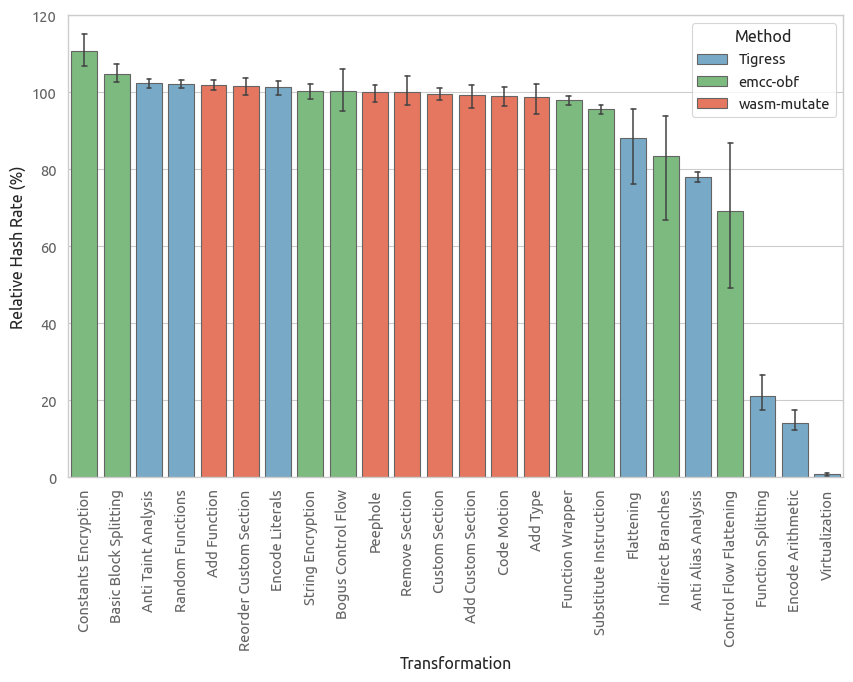

In [14]:
def plot_hash_rates(df, xlabel, palette=None, path=None):
    
    # Compute the average distance for each transformation_label
    avg_distance = df.groupby('transformation_label')['relative_actual_hash_rate'].mean().reset_index()
    
    # Sort DataFrame by descending values of the average distance
    avg_distance_sorted = avg_distance.sort_values('relative_actual_hash_rate', ascending=False)

    # Use the sorted order to sort the original DataFrame by transformation_label
    df['transformation_label'] = pd.Categorical(df['transformation_label'],
                                                categories=avg_distance_sorted['transformation_label'],
                                                ordered=True)
    
    df['relative_hash_rate_percent'] = df['relative_actual_hash_rate'] * 100
    
    sorted_df = df.sort_values('transformation_label')

    sns.barplot(data=sorted_df, 
                x='transformation_label', 
                y='relative_hash_rate_percent', 
                hue='method',
                hue_order=['Tigress', 'emcc-obf', 'wasm-mutate'],
                dodge=False,
                palette=palette, 
                errwidth=1.1, 
                capsize=0.15, 
                edgecolor=edgecolor,
                )
    
    # Axis labels
    plt.ylabel('Relative Hash Rate (%)')
    plt.xlabel(xlabel)

    plt.xticks(rotation=90)

    # Capitalize the first letter of the entries in the legend
    plt.legend(title='Method', loc='upper right')

    plt.ylim(0, 120)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

    return avg_distance_sorted['transformation_label'].tolist()

# filter wasm-mutate data
filtered_wasm_mutate_data = wasm_mutate_data[wasm_mutate_data['iteration'] == -1]
filtered_wasm_mutate_data = wasm_mutate_data[wasm_mutate_data['transformation'] != 'RemoveItemMutator']

# Add a 'method' column to each dataframe
tigress_data['method'] = 'Tigress'
llvm_unoptimized['method'] = 'emcc-obf'
filtered_wasm_mutate_data['method'] = 'wasm-mutate'

# Concatenate all dataframes in the desired order: tigress, llvm, wasm_mutate
df = pd.concat([tigress_data, llvm_unoptimized, filtered_wasm_mutate_data], ignore_index=True)

prev_xtick_order = plot_hash_rates(df, xlabel='Transformation', palette=bgr_palette, path='./plots/overhead/hash-rates.pdf')

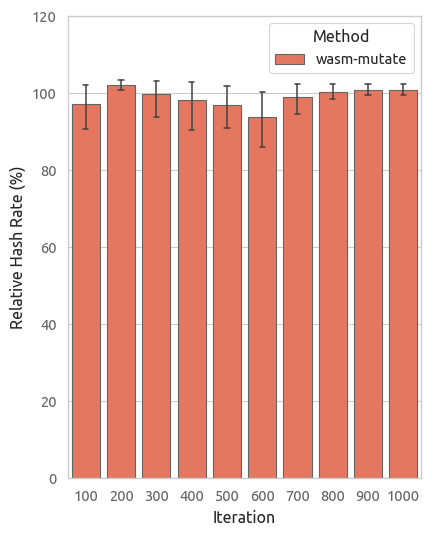

In [17]:
def plot_wasm_mutate_hash_rate(df, palette=palette, path=None):
    plt.figure(figsize=(4.55,6))

    df['relative_hash_rate_percent'] = df['relative_actual_hash_rate'] * 100

    sns.barplot(data=df, 
                x='iteration', 
                y='relative_hash_rate_percent', 
                hue='method',
                palette=palette, 
                errwidth=1.1, 
                capsize=0.15, 
                edgecolor=edgecolor,
                )
    
    # Axis labels
    plt.ylabel('Relative Hash Rate (%)')
    plt.xlabel('Iteration')

    # Capitalize the first letter of the entries in the legend
    plt.legend(title='Method', loc='upper right')
    plt.ylim(0, 120)


    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")


    # Show the plot 
    plt.show()

# Filter wasm-mutate data
df = wasm_mutate_data[wasm_mutate_data['iteration'] != -1]
df = df[df['distance'].notnull()]
df['method'] = 'wasm-mutate'

red = sns.color_palette("Reds", n_colors=1)
plot_wasm_mutate_hash_rate(df, palette=red, path='./plots/overhead/mutate-hash-rate.pdf')

#### Hash rate by category

/tmp/ipykernel_10642/2392529448.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wasm_mutate_data['method'] = 'wasm-mutate'


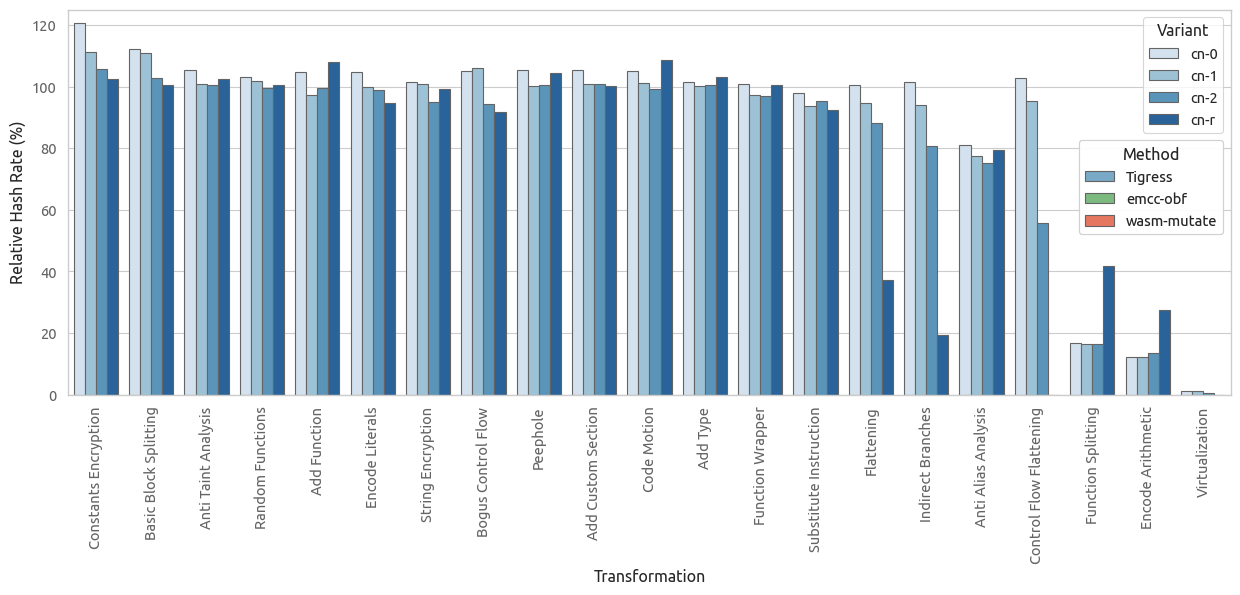

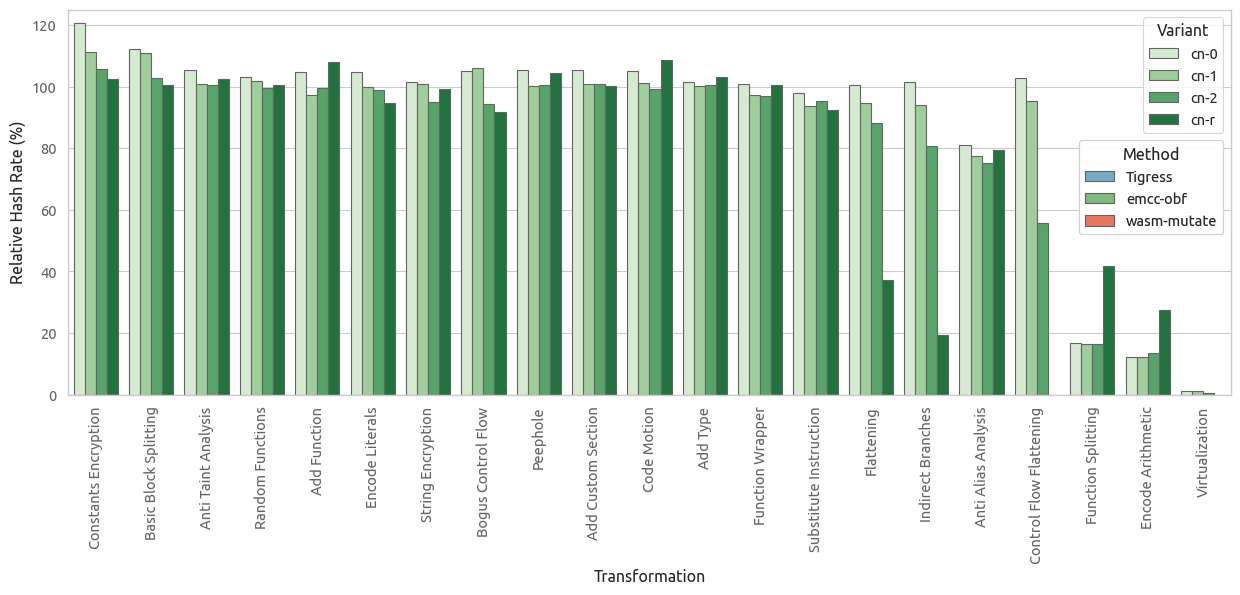

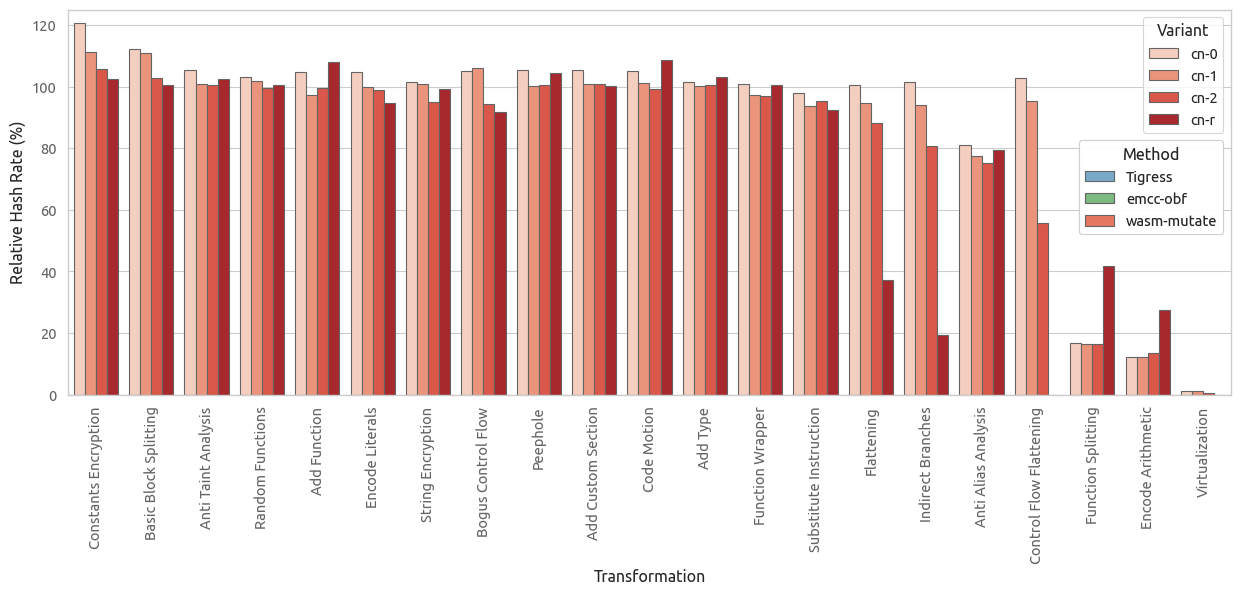

In [21]:
def plot_hash_rates_by_category(df, xlabel, xorder, palette=None, path=None):
    plt.figure(figsize=(15,5))

    # Compute the average distance for each transformation_label
    avg_distance = df.groupby('transformation_label')['relative_actual_hash_rate'].mean().reset_index()

    # Sort DataFrame by descending values of the average distance
    avg_distance_sorted = avg_distance.sort_values('relative_actual_hash_rate', ascending=False)

    # Use the sorted order to sort the original DataFrame by transformation_label
    df['transformation_label'] = pd.Categorical(df['transformation_label'],
                                                categories=avg_distance_sorted['transformation_label'],
                                                ordered=True)
    
    df['relative_hash_rate_percent'] = df['relative_actual_hash_rate'] * 100

    # Specify the desired order for the 'name' column
    name_order = ["cn-0", "cn-1", "cn-2", "cn-r"]
    df['name'] = pd.Categorical(df['name'], categories=name_order, ordered=True)

    sorted_df = df.sort_values(['transformation_label', 'name'])

    names_to_include = ["cn-0", "cn-1", "cn-2", "cn-r"]
    df = df[df['name'].isin(names_to_include)]

    ax = sns.barplot(data=sorted_df, 
                x='transformation_label', 
                y='relative_hash_rate_percent', 
                hue='name',
                order=xorder,
                palette=palette, 
                errwidth=1.1, 
                capsize=0.15, 
                edgecolor=edgecolor,
                )

    # Axis labels
    plt.ylabel('Relative Hash Rate (%)')
    plt.xlabel(xlabel)

    plt.ylim(0, 125)

    plt.xticks(rotation=90)

    # Capitalize the first letter of the entries in the legend
    variant_legend = ax.legend(title='Variant', loc='upper right')
    ax.add_artist(variant_legend)

    method_labels = df['method'].unique()
    method_colors = ["#78AAC8", "#7DBA7F", "#E57760"]
    method_handles = [Patch(facecolor=c, edgecolor=edgecolor, label=label) for label, c in zip(method_labels, method_colors)]
    method_legend = plt.legend(method_handles, method_labels, title='Method', loc='upper right', bbox_to_anchor=(1, 0.68))
    ax.add_artist(method_legend)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()


# filter wasm-mutate data
filtered_wasm_mutate_data = wasm_mutate_data[wasm_mutate_data['iteration'] == -1]

# Add a 'method' column to each dataframe
tigress_data['method'] = 'Tigress'
llvm_unoptimized['method'] = 'emcc-obf'
filtered_wasm_mutate_data['method'] = 'wasm-mutate'

# Concatenate all dataframes in the desired order: tigress, llvm, wasm_mutate
df = pd.concat([tigress_data, llvm_unoptimized, filtered_wasm_mutate_data], ignore_index=True)

prev_xtick_order.remove('Reorder Custom Section')
prev_xtick_order.remove('Remove Section')
prev_xtick_order.remove('Custom Section')

#display(Image(filename='./plots/overhead/hash-rates-variants.png'))

plot_hash_rates_by_category(df, xlabel='Transformation', xorder=prev_xtick_order, palette="Blues", path='./plots/overhead/hash-rates-variants-blues.pdf')
plot_hash_rates_by_category(df, xlabel='Transformation', xorder=prev_xtick_order, palette="Greens", path='./plots/overhead/hash-rates-variants-greens.pdf')
plot_hash_rates_by_category(df, xlabel='Transformation', xorder=prev_xtick_order, palette="Reds", path='./plots/overhead/hash-rates-variants-reds.pdf')